In [1]:
!apt update -y
!apt install -y rubberband-cli libsndfile1
!pip install pyrubberband librosa

Hit:1 http://deb.debian.org/debian buster InRelease
Get:2 http://deb.debian.org/debian buster-updates InRelease [56.6 kB]
Hit:3 http://security.debian.org/debian-security buster/updates InRelease
Fetched 56.6 kB in 0s (177 kB/s)3m
Reading package lists... Done
Building dependency tree       
Reading state information... Done
81 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
rubberband-cli is already the newest version (1.8.1-7).
libsndfile1 is already the newest version (1.0.28-6+deb10u2).
0 upgraded, 0 newly installed, 0 to remove and 81 not upgraded.

[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import pyrubberband as pyrb
import boto3
import os
import wave
from scipy import signal
%matplotlib inline
polly_client = boto3.client('polly')

In [3]:
args = {
    'Engine':'standard',
    'LanguageCode':'ja-JP',
    'OutputFormat':'pcm',
    'SampleRate':'16000',
    'Text':'かー',
    'TextType':'text',
    'VoiceId':'Mizuki'
}

In [4]:
wav_file_name = f'{args["Text"]}.wav'
work_dir_name = './work'
!mkdir -p {work_dir_name}
wav_file_path = os.path.join(work_dir_name,wav_file_name)
try:
    response = polly_client.synthesize_speech(**args)
    if 'AudioStream' in response:
        with wave.open(wav_file_path, 'wb') as wav_file:
            wav_file.setparams((1, 2, int(args['SampleRate']), 0, 'NONE', 'NONE'))
            wav_file.writeframes(response['AudioStream'].read())
except Exception as e:
    print('synthesize_speech exception: ', e)

In [5]:
amplitude, sampling_rate = sf.read("かー.wav")

In [6]:
time = np.arange(0, amplitude.shape[0])/sampling_rate

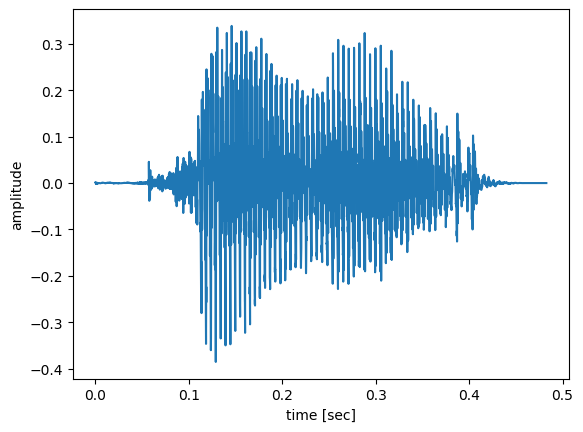

In [7]:
plt.plot(time, amplitude)
plt.xlabel('time [sec]')
plt.ylabel('amplitude')
plt.show()

Text(0, 0.5, 'amplitude')

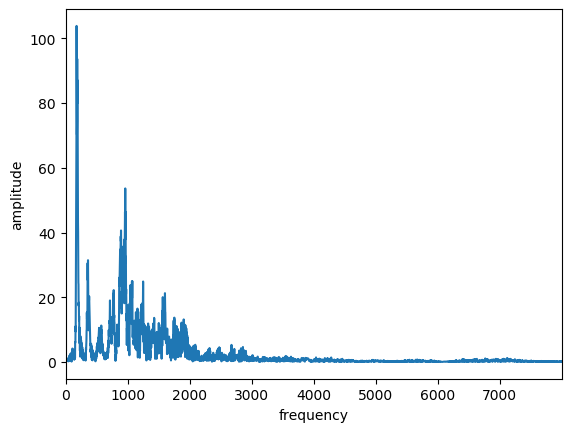

In [8]:
fft_data = np.fft.fft(amplitude)
freq_list = np.fft.fftfreq(amplitude.shape[0], d=1.0/sampling_rate)
amp = np.abs(fft_data)
amp_p = amp[0: amp.shape[0]//2]
freq_list_p = freq_list[0: freq_list.shape[0]//2]
plt.plot(freq_list_p,amp_p)
plt.xlim(0, freq_list_p[-1])
plt.xlabel('frequency')
plt.ylabel('amplitude')

maximum frequency: 176.07457276022785


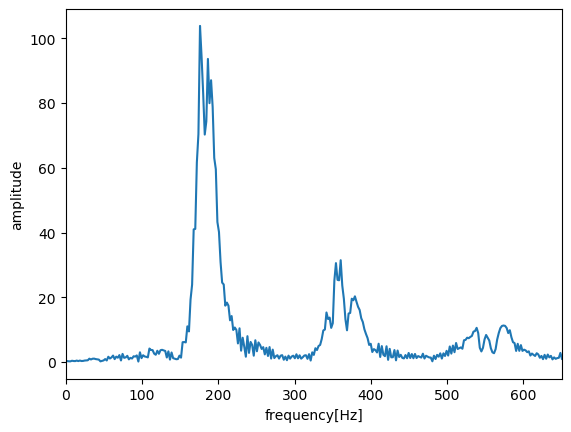

In [9]:
plt.plot(freq_list_p,amp_p)
plt.xlim(0, freq_list_p[-1])
plt.xlabel('frequency[Hz]')
plt.ylabel('amplitude')
plt.xlim(0, 650)
print('maximum frequency: '+str(freq_list_p[amp_p.argmax()]))

Text(0.5, 0, 'Time [sec]')

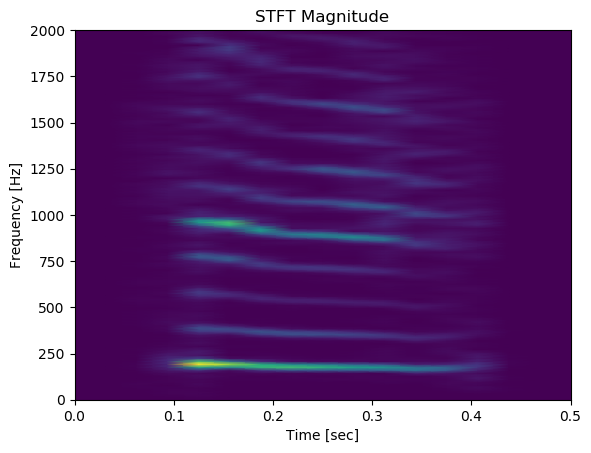

In [10]:
f, t, Zxx = signal.stft(amplitude, fs=int(args['SampleRate']), nperseg=1000)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylim(0,2000)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

In [11]:
sep_num = 4
width = amplitude.shape[0]//sep_num
segment_freq_list = []
for i in range(sep_num):
    if i==sep_num-1:
        sampling_amp = amplitude[i*width:-1]
    else:
        sampling_amp = amplitude[i*width:(i+1)*width]
    fft_data = np.fft.fft(sampling_amp)
    freq_list = np.fft.fftfreq(sampling_amp.shape[0], d=1.0/sampling_rate)
    amp = np.abs(fft_data)
    amp_p = amp[0: amp.shape[0]//2]
    freq_list_p = freq_list[0: freq_list.shape[0]//2]
    segment_freq_list.append(freq_list_p[amp_p.argmax()])
print(*segment_freq_list)

207.14655618850335 182.28896944588294 174.0031071983428 174.09326424870468


In [12]:
key_list = [
    'L-A','L-As','L-H','C','Cs','D','Ds','E','F','Fs','G','Gs','A','As','H','H-C','H-Cs','H-D','H-Ds','H-E','H-F','H-Fs','H-G','H-Gs','H-A'
]

In [13]:
key_freq_dict = {}
for i, key in enumerate(key_list):
    freq = 442 * (2 ** ((-12+i)/12))
    key_freq_dict[key] = freq
print(key_freq_dict)

{'L-A': 221.0, 'L-As': 234.14134385340427, 'L-H': 248.06411267637145, 'C': 262.81477241560134, 'Cs': 278.442552026767, 'D': 294.9996077715776, 'Ds': 312.54119728445403, 'E': 331.1258639897466, 'F': 350.8156324849721, 'Fs': 371.6762155421418, 'G': 393.77723341802994, 'Gs': 417.19244620530856, 'A': 442.0, 'As': 468.28268770680853, 'H': 496.1282253527429, 'H-C': 525.6295448312027, 'H-Cs': 556.885104053534, 'H-D': 589.9992155431552, 'H-Ds': 625.0823945689081, 'H-E': 662.2517279794932, 'H-F': 701.6312649699441, 'H-Fs': 743.3524310842836, 'H-G': 787.5544668360599, 'H-Gs': 834.384892410617, 'H-A': 884.0}


In [16]:
target_freq = key_freq_dict['C']
shift_y_list = []
data_points = 0
for i, origin_freq in enumerate(segment_freq_list):
    n_steps = np.log2(target_freq/origin_freq) * 12
    if i == sep_num-1:
        shift_y_list.append(pyrb.pitch_shift(amplitude[i*width:-1], sr = sampling_rate, n_steps=n_steps))
    else:
        shift_y_list.append(pyrb.pitch_shift(amplitude[i*width:(i+1)*width], sr = sampling_rate, n_steps=n_steps))
    data_points += shift_y_list[-1].shape[0]

In [17]:
shift_y = np.zeros((data_points),dtype=np.float64)
start_index = 0
for i in range(sep_num):
    shift_y[start_index:start_index + shift_y_list[i].shape[0]] = shift_y_list[i]
    start_index += shift_y_list[i].shape[0]

In [18]:
shift_wav_path = os.path.join(work_dir_name, 'shift.wav')
sf.write(shift_wav_path, shift_y, sampling_rate, subtype="PCM_16")

In [24]:
sampling_rate

16000